In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
from pyxu.operator import Convolve

# Convolution with Pyxu

## 0) Install dependencies

You'll need some additional dependencies to run this example:

* tqdm (https://tqdm.github.io/)
* scico (https://scico.readthedocs.io/en/latest/index.html)
* pylops (https://pylops.readthedocs.io/en/stable/index.html)

Warning: this notebook benchmarks different packages and can take a few minutes to execute. 

## 1) Prepare data

#### Create input image
We first start creating a 2D binary image of size 128x128 with blobs, where the blobs occupy approximately 20% of the image's area and are about half the size of the image. 

The resulting binary image is then converted to a floating-point representation.

In [2]:
npix = 128
data = skimage.data.binary_blobs(
    length=npix, blob_size_fraction=0.5, n_dim=2, volume_fraction=0.2
).astype(float)

#### Create blurring kernel


In [3]:
sigma = 2  # Gaussian kernel std
width = 11  # Length of the Graussian kernel
gauss = lambda x: (1 / (2 * np.pi * sigma**2)) * np.exp(
    -0.5 * ((x - (width - 1) / 2) ** 2) / (sigma**2)
)
kernel_1d = np.fromfunction(gauss, (width,))
kernel_2d = np.outer(kernel_1d.reshape(-1, 1), kernel_1d.reshape(1, -1))

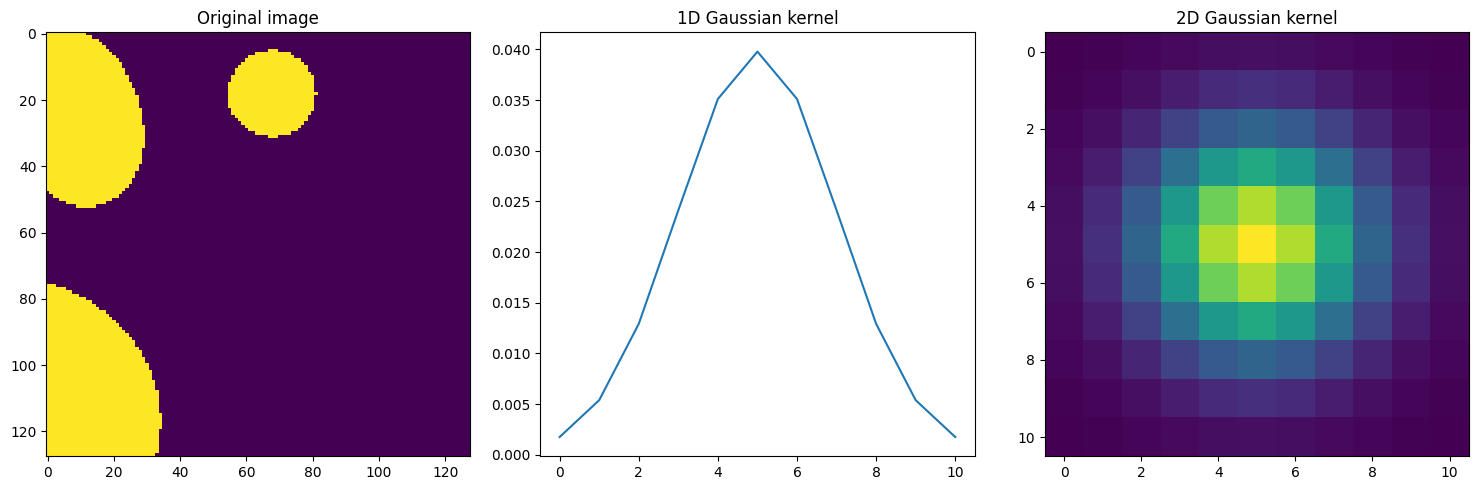

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(data), axs[0].set_title("Original image")
axs[1].plot(kernel_1d), axs[1].set_title("1D Gaussian kernel")
axs[2].imshow(kernel_2d), axs[2].set_title("2D Gaussian kernel")
fig.tight_layout()

## 2) Convolve image

#### Scipy

If you want to use scipy.signal.convolve to perform 2D convolution, it expects the kernel to match the dimensionality of the input data. So, for 2D data, you would generally provide a 2D kernel.

In [28]:
from scipy.signal import convolve as conv_scipy

# Direct 2D convolution
y = conv_scipy(data, kernel_2d, mode="same", method="direct")

However, when dealing with a separable kernel (like a Gaussian kernel), you can take advantage of the kernel's separability to perform convolution more efficiently:

- First, convolve the input 2D data with the 1D kernel along one dimension (e.g., rows).
- Then, convolve the result from the first step with the same 1D kernel along the other dimension (e.g., columns).

In [29]:
# Separable convolution

convolved_rows = conv_scipy(
    data, kernel_1d[:, np.newaxis], mode="same", method="direct"
)  # Along rows
y_separable = conv_scipy(
    convolved_rows, kernel_1d[np.newaxis, :], mode="same", method="direct"
)  # Along columns

assert np.allclose(y, y_separable)

#### Pyxu
Pyxu is optimized to handle separable kernels, which enhances performance. When working with such kernels, Pyxu can directly manage the separable convolution. Additionally, Pyxu leverages [Numba.stencil](https://numba.pydata.org/numba-doc/latest/user/stencil.html) to just-in-time (JIT) compile the convolution under the hood to make it faster. Here's how you can use it:

In [16]:
conv = Convolve(
    arg_shape=data.shape,
    kernel=[kernel_1d, kernel_1d],
    center=[width // 2, width // 2],
    mode="constant",
    enable_warnings=True,
)
y_pyxu = conv(data.ravel()).reshape(data.shape)

assert np.allclose(y, y_pyxu)

#### PyLops

PyLops uses a flattened (raveled) version of your 2D data when applying the linear operator, so you need to flatten and reshape your data as you move between operations. If you want to utilize separable convolution, you'd have to manually decompose the 2D kernel into two 1D kernels and then apply two separate 1D convolution operations sequentially. This adds an extra layer of complexity in the implementation compared to just using a 2D convolution directly.

In [30]:
from pyxu.operator.interop import from_sciop
import pyxu.abc as pyca

from pylops.signalprocessing import Convolve2D

# 2d convolution
conv_pylops = from_sciop(
    cls=pyca.LinOp,
    sp_op=Convolve2D(
        dims=data.shape,
        h=kernel_2d,
        offset=np.r_[width // 2, width // 2],
        axes=(0, 1),
        method="direct",
    ),
)
y_pylops = conv_pylops(data.ravel()).reshape(data.shape)
assert np.allclose(y, y_pylops)

In [39]:
# Separable convolution
conv_pylops_rows = from_sciop(
    cls=pyca.LinOp,
    sp_op=Convolve2D(
        dims=data.shape,
        h=kernel_1d[np.newaxis, :],
        offset=np.r_[0, width // 2],
        axes=(0, 1),
        method="direct",
    ),
)
conv_pylops_cols = from_sciop(
    cls=pyca.LinOp,
    sp_op=Convolve2D(
        dims=data.shape,
        h=kernel_1d[:, np.newaxis],
        offset=np.r_[width // 2, 0],
        axes=(0, 1),
        method="direct",
    ),
)

y_pylops = conv_pylops_cols(conv_pylops_rows(data.ravel())).reshape(data.shape)
assert np.allclose(y, y_pylops)

#### Scico

Like Pyxu, Scico employs JIT (Just-In-Time) compilation to speed up convolution operations. However, Scico relies on Jax, instead of Numba. This necessitates the transition of our array module from NumPy to Jax.

In a manner similar to PyLops, Scico expects the convolutional kernel to have the same dimensionality as the input image. One can opt for a more efficient combination of two 1D operators or a simpler single 2D operator.

In [34]:
from scico.linop import Convolve as Conv_scico
from jax import config
import jax.numpy as jnp

# Convert data and kernel from Numpy to Jax
data_jax = jnp.asarray(data)
k2d_jax = jnp.asarray(kernel_2d)
config.update("jax_enable_x64", True)

# 2d convolution
conv_scico = Conv_scico(
    k2d_jax,
    input_shape=data_jax.shape,
    input_dtype=data_jax.dtype,
    mode="same",
    jit=True,
)
y_scico = conv_scico(data_jax)
assert np.allclose(y, y_scico)

In [38]:
# Separable convolution
k1d_jax = jnp.asarray(kernel_1d)

conv_scico_rows = Conv_scico(
    k1d_jax[np.newaxis, :],
    input_shape=data_jax.shape,
    input_dtype=data_jax.dtype,
    mode="same",
    jit=True,
)
conv_scico_cols = Conv_scico(
    k1d_jax[:, np.newaxis],
    input_shape=data_jax.shape,
    input_dtype=data_jax.dtype,
    mode="same",
    jit=True,
)
y_scico = conv_scico_cols(conv_scico_rows(data_jax))
assert np.allclose(y, y_scico)

## 3) Benchmark convolution runtime across all libraries


#### Separable 1d convolution

In [ ]:
import time
import tqdm

npixs = [2**i for i in range(6, 10)]
nwidths = [2**i + 1 for i in range(3, 8)]

t_pyxu = np.full((2, len(npixs), len(nwidths)), np.nan)
t_scipy = np.full((2, len(npixs), len(nwidths)), np.nan)
t_pylops = np.full((2, len(npixs), len(nwidths)), np.nan)
t_scico = np.full((2, len(npixs), len(nwidths)), np.nan)

sigma = 2
gauss = lambda x: (1 / (2 * np.pi * sigma**2)) * np.exp(
    -0.5 * ((x - (width - 1) / 2) ** 2) / (sigma**2)
)

nreps = 5

with tqdm.tqdm(total=len(npixs) * len(nwidths)) as pbar:
    for i, npix in enumerate(npixs):
        x = skimage.data.binary_blobs(
            length=npix, blob_size_fraction=0.5, n_dim=2, volume_fraction=0.2
        ).astype(float)
        for j, width in enumerate(nwidths):
            if npix > (width * 2):
                kernel = np.fromfunction(gauss, (width,))
                data_jax = jnp.asarray(data)
                k1d_jax = jnp.asarray(kernel_1d)

                ## PYXU

                # Instantation + first run time
                tic = time.perf_counter()
                conv_pyxu = Convolve(
                    arg_shape=data.shape,
                    kernel=[kernel, kernel],
                    center=[width // 2, width // 2],
                    mode="constant",
                    enable_warnings=True,
                )
                y = conv_pyxu(data.ravel()).reshape(data.shape)
                t_pyxu[0, i, j] = time.perf_counter() - tic

                # Run time
                times = 0
                for _ in range(nreps):
                    tic = time.perf_counter()
                    y = conv_pyxu(data.ravel()).reshape(data.shape)
                    times += time.perf_counter() - tic

                t_pyxu[1, i, j] = times / nreps

                ## SCIPY

                # Instantation + first run time
                tic = time.perf_counter()
                convolved_rows = conv_scipy(
                    data, kernel_1d[:, np.newaxis], mode="same", method="direct"
                )  # Along rows
                y_scipy = conv_scipy(
                    convolved_rows,
                    kernel_1d[np.newaxis, :],
                    mode="same",
                    method="direct",
                )  # Along columns

                t_scipy[0, i, j] = time.perf_counter() - tic

                # Run time
                times = 0
                for _ in range(nreps):
                    tic = time.perf_counter()
                    convolved_rows = conv_scipy(
                        data, kernel_1d[:, np.newaxis], mode="same", method="direct"
                    )  # Along rows
                    y_scipy = conv_scipy(
                        convolved_rows,
                        kernel_1d[np.newaxis, :],
                        mode="same",
                        method="direct",
                    )  # Along columns
                    times += time.perf_counter() - tic

                t_scipy[1, i, j] = times / nreps

                ## PYLOPS

                # Instantation + first run time
                tic = time.perf_counter()
                conv_pylops_rows = from_sciop(
                    cls=pyca.LinOp,
                    sp_op=Convolve2D(
                        dims=data.shape,
                        h=kernel_1d[np.newaxis, :],
                        offset=np.r_[0, width // 2],
                        axes=(0, 1),
                        method="direct",
                    ),
                )
                conv_pylops_cols = from_sciop(
                    cls=pyca.LinOp,
                    sp_op=Convolve2D(
                        dims=data.shape,
                        h=kernel_1d[:, np.newaxis],
                        offset=np.r_[width // 2, 0],
                        axes=(0, 1),
                        method="direct",
                    ),
                )

                y_pylops = conv_pylops_cols(conv_pylops_rows(data.ravel())).reshape(
                    data.shape
                )
                t_pylops[0, i, j] = time.perf_counter() - tic

                # Run time
                times = 0
                for _ in range(nreps):
                    tic = time.perf_counter()
                    y_pylops = conv_pylops_cols(conv_pylops_rows(data.ravel())).reshape(
                        data.shape
                    )
                    times += time.perf_counter() - tic
                t_pylops[1, i, j] = times / nreps

                ## SCICO

                # Instantation + first run time

                tic = time.perf_counter()
                config.update("jax_enable_x64", True)

                conv_scico_rows = Conv_scico(
                    k1d_jax[np.newaxis, :],
                    input_shape=data_jax.shape,
                    input_dtype=data_jax.dtype,
                    mode="same",
                    jit=True,
                )
                conv_scico_cols = Conv_scico(
                    k1d_jax[:, np.newaxis],
                    input_shape=data_jax.shape,
                    input_dtype=data_jax.dtype,
                    mode="same",
                    jit=True,
                )
                y_scico = conv_scico_cols(conv_scico_rows(data_jax))
                t_scico[0, i, j] = time.perf_counter() - tic

                # Run time
                times = 0
                for _ in range(nreps):
                    tic = time.perf_counter()
                    y_scico = conv_scico_cols(conv_scico_rows(data_jax))
                    times += time.perf_counter() - tic
                t_scico[1, i, j] = times / nreps
            pbar.update(1)

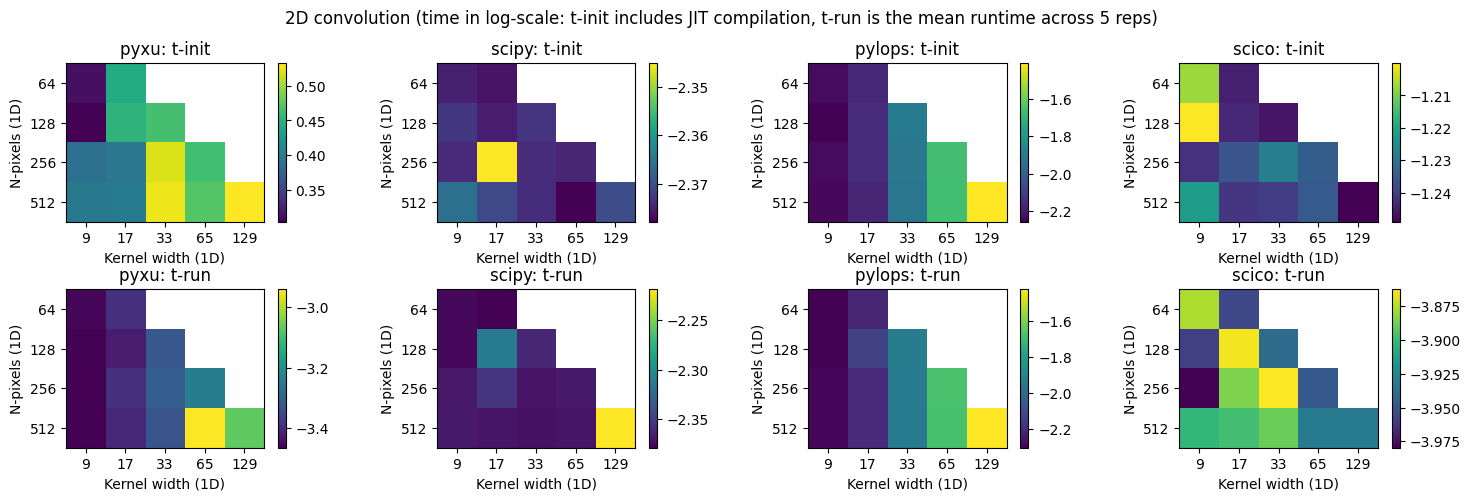

In [42]:
fig, axs = plt.subplots(2, 4, figsize=(15, 5))
im = axs[0, 0].imshow(np.log10(t_pyxu[0]))
axs[0, 0].set_title("pyxu: t-init")
plt.colorbar(im, ax=axs[0, 0])

im = axs[0, 1].imshow(np.log10(t_scipy[0]))
axs[0, 1].set_title("scipy: t-init")
plt.colorbar(im, ax=axs[0, 1])

im = axs[0, 2].imshow(np.log10(t_pylops[0]))
axs[0, 2].set_title("pylops: t-init")
plt.colorbar(im, ax=axs[0, 2])


im = axs[0, 3].imshow(np.log10(t_scico[0]))
axs[0, 3].set_title("scico: t-init")
plt.colorbar(im, ax=axs[0, 3])

im = axs[1, 0].imshow(np.log10(t_pyxu[1]))
axs[1, 0].set_title("pyxu: t-run")
plt.colorbar(im, ax=axs[1, 0])

im = axs[1, 1].imshow(np.log10(t_scipy[1]))
axs[1, 1].set_title("scipy: t-run")
plt.colorbar(im, ax=axs[1, 1])

im = axs[1, 2].imshow(np.log10(t_pylops[1]))
axs[1, 2].set_title("pylops: t-run")
plt.colorbar(im, ax=axs[1, 2])

im = axs[1, 3].imshow(np.log10(t_scico[1]))
axs[1, 3].set_title("scico: t-run")
plt.colorbar(im, ax=axs[1, 3])

for ax in axs.ravel():
    ax.set_xticks(np.arange(len(nwidths)))
    ax.set_xticklabels(nwidths)
    ax.set_xlabel("Kernel width (1D)")
    ax.set_yticks(np.arange(len(npixs)))
    ax.set_yticklabels(npixs)
    ax.set_ylabel("N-pixels (1D)")

fig.suptitle(
    f"2D convolution (time in log-scale: t-init includes JIT compilation, t-run is the mean runtime across {nreps} reps)"
)
fig.tight_layout()

#### Direct 2d convolution

In [43]:
import time
import tqdm

npixs = [2**i for i in range(6, 10)]
nwidths = [2**i + 1 for i in range(3, 8)]

t_pyxu = np.full((2, len(npixs), len(nwidths)), np.nan)
t_scipy = np.full((2, len(npixs), len(nwidths)), np.nan)
t_pylops = np.full((2, len(npixs), len(nwidths)), np.nan)
t_scico = np.full((2, len(npixs), len(nwidths)), np.nan)

sigma = 2
gauss = lambda x: (1 / (2 * np.pi * sigma**2)) * np.exp(
    -0.5 * ((x - (width - 1) / 2) ** 2) / (sigma**2)
)

nreps = 5

with tqdm.tqdm(total=len(npixs) * len(nwidths)) as pbar:
    for i, npix in enumerate(npixs):
        x = skimage.data.binary_blobs(
            length=npix, blob_size_fraction=0.5, n_dim=2, volume_fraction=0.2
        ).astype(float)
        for j, width in enumerate(nwidths):
            if npix > (width * 2):
                kernel = np.fromfunction(gauss, (width,))
                kernel_2d = np.outer(kernel.reshape(-1, 1), kernel.reshape(1, -1))
                x_jax = jnp.asarray(x)
                k2d_jax = jnp.asarray(kernel_2d)

                ## PYXU

                # Instantation + first run time
                tic = time.perf_counter()
                conv_pyxu = Convolve(
                    arg_shape=x.shape,
                    kernel=kernel_2d,
                    center=[width // 2, width // 2],
                    mode="constant",
                    enable_warnings=True,
                )
                y = conv_pyxu(x.ravel()).reshape(x.shape)
                t_pyxu[0, i, j] = time.perf_counter() - tic

                # Run time
                times = 0
                for _ in range(nreps):
                    tic = time.perf_counter()
                    y = conv_pyxu(x.ravel()).reshape(x.shape)
                    times += time.perf_counter() - tic

                t_pyxu[1, i, j] = times / nreps

                ## SCIPY

                # Instantation + first run time
                tic = time.perf_counter()
                y_scipy = conv_scipy(x, kernel_2d, mode="same", method="direct")
                t_scipy[0, i, j] = time.perf_counter() - tic

                # Run time
                times = 0
                for _ in range(nreps):
                    tic = time.perf_counter()
                    y_scipy = conv_scipy(x, kernel_2d, mode="same", method="direct")
                    times += time.perf_counter() - tic

                t_scipy[1, i, j] = times / nreps

                ## PYLOPS

                # Instantation + first run time
                tic = time.perf_counter()
                conv_pylops = from_sciop(
                    cls=pyca.LinOp,
                    sp_op=Convolve2D(
                        dims=x.shape,
                        h=kernel_2d,
                        offset=np.r_[width // 2, width // 2],
                        axes=(0, 1),
                        method="direct",
                    ),
                )

                y_pylops = conv_pylops(x.ravel()).reshape(x.shape)
                t_pylops[0, i, j] = time.perf_counter() - tic

                # Run time
                times = 0
                for _ in range(nreps):
                    tic = time.perf_counter()
                    y_pylops = conv_pylops(x.ravel()).reshape(x.shape)
                    times += time.perf_counter() - tic
                t_pylops[1, i, j] = times / nreps

                ## SCICO

                # Instantation + first run time

                tic = time.perf_counter()
                conv_scico = Conv_scico(
                    k2d_jax,
                    input_shape=x_jax.shape,
                    input_dtype=x_jax.dtype,
                    mode="same",
                    jit=True,
                )
                y_scico = conv_scico(x_jax)
                t_scico[0, i, j] = time.perf_counter() - tic

                # Run time
                times = 0
                for _ in range(nreps):
                    tic = time.perf_counter()
                    y_scico = conv_scico(x_jax)
                    times += time.perf_counter() - tic
                t_scico[1, i, j] = times / nreps
            pbar.update(1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [13:43<00:00, 41.15s/it]


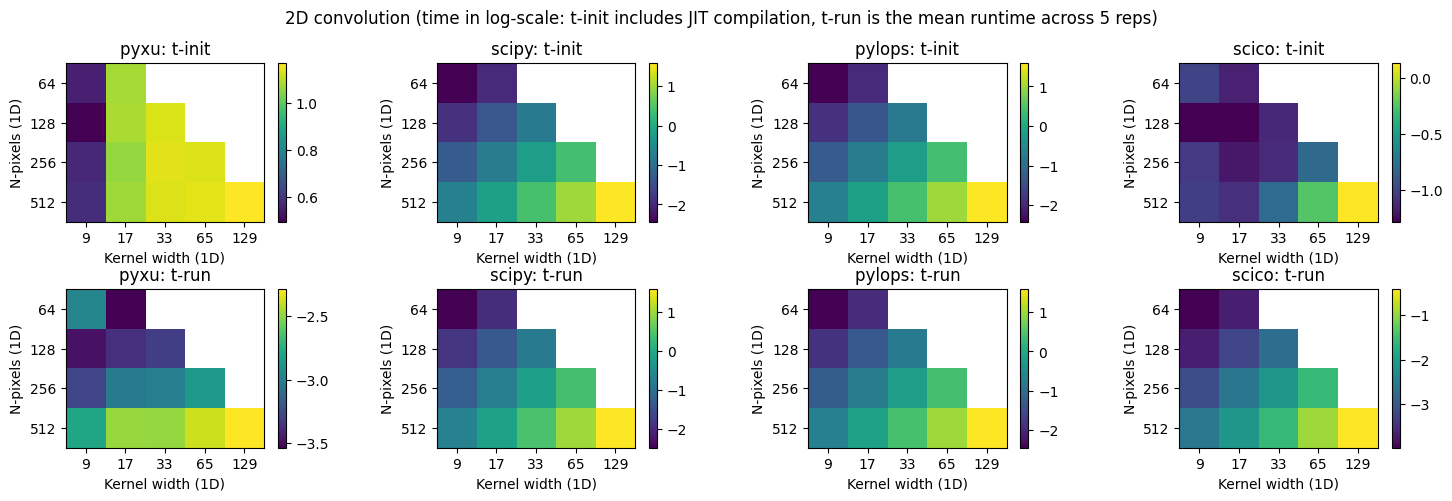

In [55]:
fig, axs = plt.subplots(2, 4, figsize=(15, 5))

im = axs[0, 0].imshow(np.log10(t_pyxu[0]))
axs[0, 0].set_title("pyxu: t-init")
plt.colorbar(im, ax=axs[0, 0])

im = axs[0, 1].imshow(np.log10(t_scipy[0]))
axs[0, 1].set_title("scipy: t-init")
plt.colorbar(im, ax=axs[0, 1])

im = axs[0, 2].imshow(np.log10(t_pylops[0]))
axs[0, 2].set_title("pylops: t-init")
plt.colorbar(im, ax=axs[0, 2])


im = axs[0, 3].imshow(np.log10(t_scico[0]))
axs[0, 3].set_title("scico: t-init")
plt.colorbar(im, ax=axs[0, 3])

im = axs[1, 0].imshow(np.log10(t_pyxu[1]))
axs[1, 0].set_title("pyxu: t-run")
plt.colorbar(im, ax=axs[1, 0])

im = axs[1, 1].imshow(np.log10(t_scipy[1]))
axs[1, 1].set_title("scipy: t-run")
plt.colorbar(im, ax=axs[1, 1])

im = axs[1, 2].imshow(np.log10(t_pylops[1]))
axs[1, 2].set_title("pylops: t-run")
plt.colorbar(im, ax=axs[1, 2])

im = axs[1, 3].imshow(np.log10(t_scico[1]))
axs[1, 3].set_title("scico: t-run")
plt.colorbar(im, ax=axs[1, 3])

for ax in axs.ravel():
    ax.set_xticks(np.arange(len(nwidths)))
    ax.set_xticklabels(nwidths)
    ax.set_xlabel("Kernel width (1D)")
    ax.set_yticks(np.arange(len(npixs)))
    ax.set_yticklabels(npixs)
    ax.set_ylabel("N-pixels (1D)")

fig.suptitle(
    f"2D convolution (time in log-scale: t-init includes JIT compilation, t-run is the mean runtime across {nreps} reps)"
)
fig.tight_layout()